# Recommendation Systems

In [226]:
#importing the required libraries
import pandas as pd
import numpy as np

#compare ensemble to each baseline classifier
from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings("ignore")

#For visualization
import seaborn as sns
import matplotlib.pyplot as plt  
sns.set(color_codes=True)        #adds color background (have to kill the kernel to see the changes of color)
%matplotlib inline 

#For scientific computations
from scipy import stats

from surprise.model_selection import RandomizedSearchCV
from surprise.model_selection import GridSearchCV

from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD, SVDpp
from surprise import KNNBasic
from surprise import KNNWithMeans

import requests
from io import StringIO

#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
import math
import re
from scipy.sparse import csr_matrix

In [227]:
# importing all 6 input files
df1 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 6 - RS\\phone_user_review_file_1.csv',encoding='latin')
df2 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 6 - RS\\phone_user_review_file_2.csv',encoding='latin')
df3 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 6 - RS\\phone_user_review_file_3.csv',encoding='latin')
df4 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 6 - RS\\phone_user_review_file_4.csv',encoding='latin')
df5 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 6 - RS\\phone_user_review_file_5.csv',encoding='latin')
df6 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 6 - RS\\phone_user_review_file_6.csv',encoding='latin')

In [228]:
# Merging all 6 datasets
df = pd.concat([df1,df2,df3,df4,df5,df6], axis=0)
print('Shape of data file is: {}'.format(df.shape))

Shape of data file is: (1415133, 11)


In [229]:
df.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [230]:
df.dtypes

phone_url     object
date          object
lang          object
country       object
source        object
domain        object
score        float64
score_max    float64
extract       object
author        object
product       object
dtype: object

All features are of 'object' datatype except for score and score_max which are 'float64' datatype.

In [231]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
score,1351644.0,8.00706,2.616121,0.2,7.2,9.2,10.0,10.0
score_max,1351644.0,10.00000,0.000000,10.0,10.0,10.0,10.0,10.0


We can observe that min, max and mean values in 'score_max' column are all the same and standard deviation is 0. Hence, we can drop this feature as it is not useful in our analysis. Feature 'score' has minimum value of 0.2 and maximum of 10 with standard deviation of 2.6. Also, we can observe that the mean is around 8.

In [232]:
# Let's check for missing values and impute if neccessary
df.isnull().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        63489
score_max    63489
extract      19361
author       63202
product          1
dtype: int64

Missing values are found in 'score', 'score_max', 'extract', 'author' and one in 'product' column. Since few columns are not important, first we will remove these features and then we will impute missing values in remaining columns.

In [233]:
# Lets drop 'phone_url', 'domain', 'score_max', 'extract' columns as they are not useful for our analysis
df.drop(['phone_url', 'domain', 'score_max', 'extract'], axis = 1, inplace = True)
df.head()

,date,lang,country,source,score,author,product
0,5/2/2017,en,us,Verizon Wireless,10.0,CarolAnn35,Samsung Galaxy S8
1,4/28/2017,en,us,Phone Arena,10.0,james0923,Samsung Galaxy S8
2,5/4/2017,en,us,Amazon,6.0,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,5/2/2017,en,us,Samsung,9.2,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,5/11/2017,en,us,Verizon Wireless,4.0,S Ate Mine,Samsung Galaxy S8


In [234]:
# Imputing score column with mean value
df['score'].fillna(df['score'].mean(), inplace=True)

In [235]:
# Dropping null values from column 'author' and 'product'
df = df.dropna(axis = 0, how ='any')

In [236]:
df.isnull().sum()

date       0
lang       0
country    0
source     0
score      0
author     0
product    0
dtype: int64

In [237]:
print('Shape of data file after missing value treatment and removing unwanted features is: {}'.format(df.shape))

Shape of data file after missing value treatment and removing unwanted features is: (1351931, 7)


We have eliminated 4 columns and 63202 rows from the actual dataset.

In [238]:
# We will round off scores to the nearest integers.

df['score'] = df['score'].round().astype(int)
df.head()

,date,lang,country,source,score,author,product
0,5/2/2017,en,us,Verizon Wireless,10,CarolAnn35,Samsung Galaxy S8
1,4/28/2017,en,us,Phone Arena,10,james0923,Samsung Galaxy S8
2,5/4/2017,en,us,Amazon,6,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,5/2/2017,en,us,Samsung,9,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,5/11/2017,en,us,Verizon Wireless,4,S Ate Mine,Samsung Galaxy S8


We can observe that values in 'score' column has been rounded off to nearest integers.

In [239]:
# Check for duplicates and remove them using author and product columns

df_new = df.drop_duplicates(subset=['date', 'source', 'author', 'product'], keep='first', inplace=False, ignore_index=False)
df_new.tail()

,date,lang,country,source,score,author,product
163832,5/12/2000,de,de,Ciao,2,david.paul,Alcatel Club Plus Handy
163833,5/11/2000,de,de,Ciao,10,Christiane14,Alcatel Club Plus Handy
163834,5/4/2000,de,de,Ciao,2,michaelawr,Alcatel Club Plus Handy
163835,5/1/2000,de,de,Ciao,8,claudia0815,Alcatel Club Plus Handy
163836,4/25/2000,de,de,Ciao,2,michaelawr,Alcatel Club Plus Handy


In [240]:
print('Shape of data file after removing duplicate ratings from users on the same product is: {}'.format(df_new.shape))

Shape of data file after removing duplicate ratings from users on the same product is: (1258038, 7)


In [241]:
# Sampling data to keep only 1000000 rows 

df_samp = df_new.sample(n=1000000, random_state=612)
print('Shape of data file after sampling is: {}'.format(df_samp.shape))

Shape of data file after sampling is: (1000000, 7)


In [242]:
df_samp = df_samp.reset_index(drop=True)
df_samp.head()

,date,lang,country,source,score,author,product
0,8/19/2009,en,us,Newegg,6,Alan C.,Nokia E63 110 MB Blue Unlocked GSM Smart Phone...
1,7/23/2013,fr,fr,Amazon,10,Robert Anouk,universel Etui Sony Xperia J ST26I slim cuir noir
2,7/15/2014,pt,br,Americanas,8,Bruno Kanitz,Nokia Smartphone Nokia Lumia 925 Desbloqueado ...
3,8/22/2013,en,us,Amazon,10,Sharon C Karnes,LG Optimus Extreme Android Prepaid Phone (Net10)
4,11/26/2015,en,gb,Amazon,4,ripon,Apple iPhone 6s Plus Silver 128GB (UK Version)...


In [243]:
print('The top ten products with most number of reviews are:')
products_rated_count = df_samp.groupby('product')['score'].count().sort_values(ascending=False)
products_rated_count.head(10)

The top ten products with most number of reviews are:


product
OnePlus 3 (Graphite, 64 GB)               1791
Lenovo Vibe K4 Note (White,16GB)          1750
Samsung Galaxy Express I8730              1727
Samsung Galaxy J3 (8GB)                   1496
Lenovo Vibe K4 Note (Black, 16GB)         1496
OnePlus 3 (Soft Gold, 64 GB)              1435
Nokia N95                                 1433
Samsung Galaxy S7 edge 32GB (Verizon)     1407
Samsung Galaxy S7 edge 32GB (T-Mobile)    1352
Nokia 5800 XpressMusic                    1304
Name: score, dtype: int64

In [244]:
print('The top ten authors who have given most number of reviews are:')
user_rated_count = df_samp.groupby('author')['score'].count().sort_values(ascending=False)
user_rated_count.head(10)

The top ten authors who have given most number of reviews are:


author
Amazon Customer    17764
Cliente Amazon     10572
e-bit               4581
Amazon Kunde        3594
Client d'Amazon     2694
Anonymous           2086
einer Kundin        1440
einem Kunden        1131
Anonymous           1053
unknown              802
Name: score, dtype: int64

In [245]:
print('Count of products having more than 50 reviews      : {}'.format(sum(products_rated_count >= 50)) )
print('Count of users who have given more than 50 reviews : {}'.format(sum(user_rated_count >= 50)) )

Count of products having more than 50 reviews      : 4631
Count of users who have given more than 50 reviews : 717


In [246]:
df_fin = df_samp.groupby(["product", "author"]).filter(lambda x:x['score'].count() >=50)
df_fin = df_fin.reset_index(drop=True)
df_fin.head()

,date,lang,country,source,score,author,product
0,8/3/2016,it,it,Amazon,10,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ..."
1,8/14/2016,de,de,Otto.de,10,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1..."
2,11/6/2015,it,it,Amazon,10,Cliente Amazon,Lenovo Motorola Moto G 4G 3 Generazione Smartp...
3,10/10/2015,de,de,Otto.de,10,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB"
4,5/7/2016,de,de,Otto.de,10,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1..."


In [247]:
# df_sel1 = df_samp.groupby(["author"]).filter(lambda x:x['product'].count() >=50)
# df_sel2 = df_samp.groupby(["product"]).filter(lambda x:x['author'].count() >=50)
# df_sel = pd.concat([df_sel1,df_sel2], axis=0)
# # df_fin = df_fin.reset_index(drop=True)
# df_sel.shape

In [248]:
# df_sel1 = df_sel.drop_duplicates(subset=['author', 'product', 'score'], keep='first', inplace=False, ignore_index=False)
# df_sel1.shape

In [249]:
print('Shape of data file having product rated more than 50 times and users who have rated more than 50 times is: {}'.format(df_fin.shape))

Shape of data file having product rated more than 50 times and users who have rated more than 50 times is: (6250, 7)


### Popularity based recommedation system
The Popularity based recommendation system is one of the commonly used model. This is not actually personalized, it simply recommends to a user the most popular product that the user has not previously used.

In [250]:
mean_count_prod = pd.DataFrame(df_fin.groupby('product')['score'].mean())
mean_count_prod['prod_counts'] = pd.DataFrame(df_fin.groupby('product')['score'].count())
mean_count_prod.head(5)

,score,prod_counts
product,,
"Alcatel One Touch 20-04G Telefono Cellulare, Nero",8.867925,53
Apple Apple iPhone 5s - 32GB - Zilver,9.169231,65
"Apple iPhone 6s 4,7"" 128 GB",9.802469,162
"Apple iPhone 6s Plus 5,5"" 128 GB",9.743119,109
"Apple iPhone 7 4,7"" 32 GB",9.752381,210


In [251]:
mean_count_user = pd.DataFrame(df_fin.groupby('author')['score'].mean())
mean_count_user['user_counts'] = pd.DataFrame(df_fin.groupby('author')['score'].count())
mean_count_user.head()

,score,user_counts
author,,
Amazon Customer,6.232143,224
Amazon Kunde,7.683333,120
Anonymous,8.807692,52
Cliente Amazon,8.479918,971
e-bit,8.906333,2637


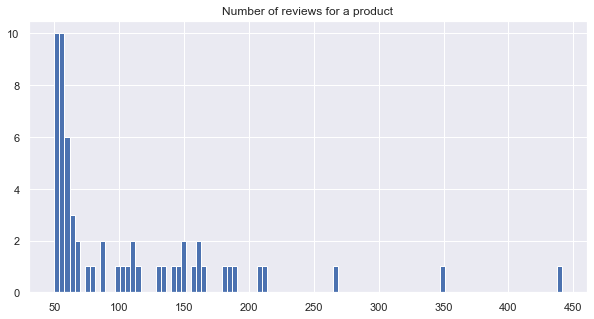

In [252]:
plt.figure(figsize=(10,5))
plt.title('Number of reviews for a product')
plt.rcParams['patch.force_edgecolor'] = True
mean_count_prod['prod_counts'].hist(bins=100);

We can see that most of the products have less than 200 reviews.

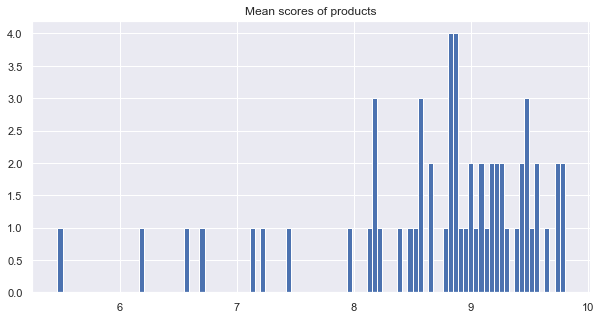

In [253]:
plt.figure(figsize=(10,5))
plt.title('Mean scores of products')
plt.rcParams['patch.force_edgecolor'] = True
mean_count_prod['score'].hist(bins=100);

We can observe that most of the producs have mean scores between 8.5 and 10.

<Figure size 720x360 with 0 Axes>

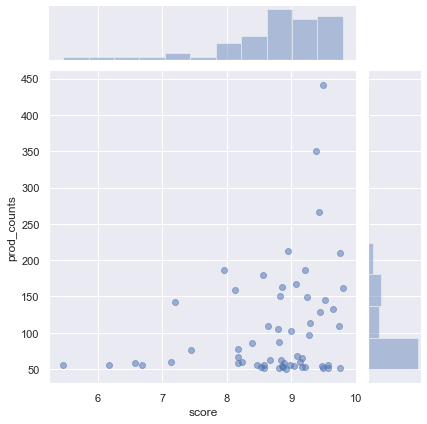

In [254]:
plt.figure(figsize=(10,5))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='score', y='prod_counts', data=mean_count_prod, alpha=0.5);

From the plot we can observe that products have more number of reviews have higher mean scores in general.

In [255]:
print('Top 5 popular products recommended are:')
df_fin.groupby('product')['score'].mean().sort_values(ascending=False).head()

Top 5 popular products recommended are:


product
Apple iPhone 6s 4,7" 128 GB          9.802469
Smartphone Asus ZenFone 3 ZE552KL    9.764706
Apple iPhone 7 4,7" 32 GB            9.752381
Apple iPhone 6s Plus 5,5" 128 GB     9.743119
Smartphone LG G2 D805                9.654135
Name: score, dtype: float64

As we can see above we can observe that 3 out of 5 products are of Apple origin, other two products belong to Asus and LG companies. Also we can say that we have reviews from different users since we have removed multiple reviews from a single user by dropping duplicates. Thus, we can say that this is an effective approach and reliable popularity based recommendation.

### Collaborative filtering using SVD (Model based)
The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler. It provides another way to factorize a matrix, into singular vectors and singular values.

In [256]:
# Let's keep only auhtor, product and score columns in our dataset.
df_col3 = df_fin.filter(['author','product','score'])
df_col3.head()

,author,product,score
0,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",10
1,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1...",10
2,Cliente Amazon,Lenovo Motorola Moto G 4G 3 Generazione Smartp...,10
3,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",10
4,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1...",10


Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. The Reader class is used to parse a file containing ratings in surprise package.

In [257]:
reader = Reader(rating_scale=(1, 10))
surprise_df = Dataset.load_from_df(df_col3, reader)

# Split the data into train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(surprise_df, test_size=0.3, random_state=10)

In [258]:
# To get top n predictions
from collections import defaultdict

def get_top_n(predictions, n=500, latest=False):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for user, prod, true_r, est, _ in predictions:
        top_n[user].append((prod, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for user, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user] = user_ratings[:n]
    return top_n

Let's define a class and objects which will be helpful since we are going to test with different approaches.

In [259]:
# For ease of use to recommend
class collab_filtering_based_recommender():

# Initializing variables    
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

# Model fit and predict        
    def fit_and_predict_product(self):        
        printmd('**Fitting the train data...**', color='blue')
        self.model.fit(self.trainset)       

        printmd('**Predicting the test data...**', color='blue')
        self.pred_test = self.model.test(self.testset)        
        rmse = round(accuracy.rmse(self.pred_test), 3)
        printmd('**RMSE for the predicted result is ' + str(rmse) + '**', color='blue')   
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns=['author', 'product', 'score'])
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['product', 'score'])
#             print(subdf)
#             print('Here1')
            subdf['author'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]   
#             print(subdf)
#             print('Here2')
            subdf_x = subdf.drop_duplicates(subset=['product', 'score'], keep='first', inplace=False, ignore_index=False)
            subdf_x = subdf_x.reset_index(drop=True)
#             print(subdf_x)
            self.recommenddf = pd.concat([self.recommenddf, subdf_x], axis = 0)        
        return rmse

# Cross validate to get better results
    def cross_validate(self):
        printmd('**Cross Validating the data...**', color='blue')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1)
        cv_result = round(cv_result['test_rmse'].mean(),3)
        printmd('**Mean CV RMSE is ' + str(cv_result)  + '**', color='blue')
        return cv_result

# Recommending products   
    def recommend_product(self, author_name, n=500):
        printmd('**Recommending top ' + str(n)+ ' products for user ' + author_name + ' :**', color='blue')
        
        df = self.recommenddf[self.recommenddf['author'] == author_name].head(n)
#         df_x = df.drop_duplicates(subset=['author', 'product', 'score'], keep='first', inplace=False, ignore_index=False)
        display(df)
#         display('here')
        return df

In [260]:
# Finding the best model using Random search or Grid search (Grid search comparitively takes more time)

def find_best_model(model, parameters, data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
#     clf = GridSearchCV(model, parameters, measures=["rmse", "mae"], cv=3)
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

In [261]:
# Giving parameters for search CV to find best model
params= {
    "n_epochs": [5, 10, 15, 20, 25],
    "lr_all": [0.002, 0.005, 0.01, 0.02],
    "reg_all": [0.2, 0.4, 0.6, 0.8, 1]
    }
clf = find_best_model(SVD, params, surprise_df)

{'rmse': 1.7939789009973253}
{'rmse': {'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.2}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000022294B99310>}


To acheive best results we have used Random search CV for hyperparameter tuning. Grid search usually takes more time as data gets large.

In [262]:
# Giving inputs to recommender
svd = clf.best_estimator['rmse']
col_fil_svd = collab_filtering_based_recommender(svd, trainset, testset, surprise_df)

In [263]:
# Calculating RMSE
svd_rmse = col_fil_svd.fit_and_predict_product()

<span style='color:blue'>**Fitting the train data...**</span>

<span style='color:blue'>**Predicting the test data...**</span>

RMSE: 1.8221


<span style='color:blue'>**RMSE for the predicted result is 1.822**</span>

In [264]:
#cross validate
svd_cv_rmse = col_fil_svd.cross_validate()

<span style='color:blue'>**Cross Validating the data...**</span>

<span style='color:blue'>**Mean CV RMSE is 1.792**</span>

We can see that mean RMSE is > 1.5. For good predictions RMSE should be less than 1. Let's recommend and try with other approach/methods to improve the results.

In [265]:
# Recommend
result_svd_user1 = col_fil_svd.recommend_product(author_name='e-bit', n=5)
result_svd_user2 = col_fil_svd.recommend_product(author_name='einem Kunden', n=5)
result_svd_user3 = col_fil_svd.recommend_product(author_name='Cliente Amazon', n=5)

<span style='color:blue'>**Recommending top 5 products for user e-bit :**</span>

,author,product,score
0,e-bit,Smartphone Asus ZenFone 3 ZE552KL,9.399038
1,e-bit,Smartphone LG G2 D805,9.395131
2,e-bit,Smartphone Samsung Galaxy S7 SM-G930 32GB,9.314904
3,e-bit,Smartphone Apple iPhone 6 16GB,9.262745
4,e-bit,Smartphone Asus ZenFone 3 ZE520KL,9.247959


<span style='color:blue'>**Recommending top 5 products for user einem Kunden :**</span>

,author,product,score
0,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",9.723646
1,einem Kunden,"Apple iPhone 7 4,7"" 32 GB",9.674864
2,einem Kunden,"Apple iPhone 6s Plus 5,5"" 128 GB",9.605344
3,einem Kunden,"Apple iPhone 7 Plus 5,5"" 128 GB",9.452683
4,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1...",9.446536


<span style='color:blue'>**Recommending top 5 products for user Cliente Amazon :**</span>

,author,product,score
0,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...,9.224441
1,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",9.144582
2,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",8.863314
3,Cliente Amazon,"Alcatel One Touch 20-04G Telefono Cellulare, Nero",8.744071
4,Cliente Amazon,Lenovo Motorola Moto G 4G 3 Generazione Smartp...,8.715213


### Collaborative filtering model using KNN with means(Memory based)
Collaborative Filtering Using k-Nearest Neighbors (kNN) kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.

In [266]:
sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_df)

{'rmse': 1.8058834909686958}
{'rmse': {'k': 48, 'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': True}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x0000022294B81E50>}


In [267]:
knnwithmeans = clf.best_estimator['rmse']
col_fil_knnwithmeans = collab_filtering_based_recommender(knnwithmeans, trainset, testset, surprise_df)

In [268]:
knnwithmeans_rmse = col_fil_knnwithmeans.fit_and_predict_product()

<span style='color:blue'>**Fitting the train data...**</span>

Computing the cosine similarity matrix...
Done computing similarity matrix.


<span style='color:blue'>**Predicting the test data...**</span>

RMSE: 1.8324


<span style='color:blue'>**RMSE for the predicted result is 1.832**</span>

In [269]:
knnwithmeans_cv_rmse = col_fil_knnwithmeans.cross_validate()

<span style='color:blue'>**Cross Validating the data...**</span>

<span style='color:blue'>**Mean CV RMSE is 1.799**</span>

RMSE value using KNN with means also seems to be giving similar results as SVD approach.

In [270]:
result_knn_user1 = col_fil_knnwithmeans.recommend_product(author_name='e-bit', n=5)
result_knn_user2 = col_fil_knnwithmeans.recommend_product(author_name='einem Kunden', n=5)
result_knn_user3 = col_fil_knnwithmeans.recommend_product(author_name='Cliente Amazon', n=5)

<span style='color:blue'>**Recommending top 5 products for user e-bit :**</span>

,author,product,score
0,e-bit,Smartphone Asus ZenFone 3 ZE552KL,9.764706
1,e-bit,Smartphone Samsung Galaxy S7 SM-G930 32GB,9.696970
2,e-bit,Smartphone LG G2 D805,9.583333
3,e-bit,Smartphone Apple iPhone 6 16GB,9.555556
4,e-bit,Smartphone Asus ZenFone 3 ZE520KL,9.515152


<span style='color:blue'>**Recommending top 5 products for user einem Kunden :**</span>

,author,product,score
0,einem Kunden,"Apple iPhone 6s Plus 5,5"" 128 GB",9.950989
1,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",9.875000
2,einem Kunden,"Apple iPhone 7 4,7"" 32 GB",9.708333
3,einem Kunden,"Apple iPhone 7 Plus 5,5"" 128 GB",9.612325
4,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1...",9.500000


<span style='color:blue'>**Recommending top 5 products for user Cliente Amazon :**</span>

,author,product,score
0,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...,9.550000
1,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",9.380952
2,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",8.916667
3,Cliente Amazon,"Alcatel One Touch 20-04G Telefono Cellulare, Nero",8.727273
4,Cliente Amazon,Lenovo Motorola Moto G 4G 3 Generazione Smartp...,8.682927


#### Item-Item based

In [271]:
# To get top n predictions
# from collections import defaultdict

def get_top_n1(predictions1, n=10000, latest=False):
    # First map the predictions to each user.
    top_n1 = defaultdict(list)
    for user1, prod1, true_r1, est1, _ in predictions1:
        top_n1[prod1].append((user1, est1))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for prod1, user_ratings1 in top_n1.items():
        user_ratings1.sort(key=lambda x: x[1], reverse=True)
        top_n1[prod1] = user_ratings1[:n]
    return top_n1

In [272]:
# For ease of use to recommend
class collab_filtering_based_recommender1():

# Initializing variables    
    def __init__(self1, model1, trainset1, testset1, data1):
        self1.model1 = model1
        self1.trainset1 = trainset1
        self1.testset1 = testset1
        self1.data1 = data1
        self1.pred_test1 = None
        self1.recommendations1 = None
        self1.top_n1 = None
        self1.recommenddf1 = None

# Model fit and predict        
    def fit_and_predict_user(self1):        
        printmd('**Fitting the train data...**', color='blue')
        self1.model1.fit(self1.trainset1)       

        printmd('**Predicting the test data...**', color='blue')
        self1.pred_test1 = self1.model1.test(self1.testset1)        
        rmse1 = round(accuracy.rmse(self1.pred_test1), 3)
        printmd('**RMSE for the predicted result is ' + str(rmse1) + '**', color='blue')   
        
        self1.top_n1 = get_top_n1(self1.pred_test1)
        self1.recommenddf1 = pd.DataFrame(columns=['author', 'product', 'score'])
        for item1 in self1.top_n1:
            subdf1 = pd.DataFrame(self1.top_n1[item1], columns=['author', 'score'])
#             print(subdf1)
#             print('Here1')
            subdf1['product'] = item1
            cols = subdf1.columns.tolist()
#             print(cols)
            cols = cols[-1:] + cols[:-1]
            subdf1 = subdf1[cols]   
#             print(subdf1)
#             print('Here2')
            subdf_y = subdf1.drop_duplicates(subset=['author', 'score'], keep='first', inplace=False, ignore_index=False)
            subdf_y = subdf_y.reset_index(drop=True)
#             print(subdf_y)
#             print('here3')
            self1.recommenddf1 = pd.concat([self1.recommenddf1, subdf_y], axis = 0)        
        return rmse1

# Cross validate to get better results
    def cross_validate1(self1):
        printmd('**Cross Validating the data...**', color='blue')
        cv_result1 = cross_validate(self1.model1, self1.data1, n_jobs=-1)
        cv_result1 = round(cv_result1['test_rmse'].mean(),3)
        printmd('**Mean CV RMSE is ' + str(cv_result1)  + '**', color='blue')
        return cv_result1

# Recommending products   
    def recommend_user(self1, prod_name, n=10000):
        printmd('**Recommending top users for product ' + prod_name + ' :**', color='blue')
        
        df_u = self1.recommenddf1[self1.recommenddf1['product'] == prod_name].head(n)
#         df_x = df.drop_duplicates(subset=['author', 'product', 'score'], keep='first', inplace=False, ignore_index=False)
        display(df_u)
#         display('here')
        return df_u

In [273]:
# Finding the best model using Random search or Grid search (Grid search comparitively takes more time)

def find_best_model1(model1, parameters1, data1):
    clf1 = RandomizedSearchCV(model1, parameters1, n_jobs=-1, measures=['rmse'])
#     clf = GridSearchCV(model, parameters, measures=["rmse", "mae"], cv=3)
    clf1.fit(data1)             
    print(clf1.best_score)
    print(clf1.best_params)
    print(clf1.best_estimator)
    return clf1

In [274]:
# Giving parameters for search CV to find best model
params1= {
    "n_epochs": [5, 10, 15, 20, 25],
    "lr_all": [0.002, 0.005, 0.01, 0.02],
    "reg_all": [0.2, 0.4, 0.6, 0.8, 1]
    }
clf1 = find_best_model1(SVD, params1, surprise_df)

{'rmse': 1.7973725389338842}
{'rmse': {'n_epochs': 25, 'lr_all': 0.002, 'reg_all': 0.4}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000022294B81280>}


In [275]:
# Giving inputs to recommender
svd1 = clf1.best_estimator['rmse']
col_fil_svd1 = collab_filtering_based_recommender1(svd1, trainset, testset, surprise_df)

In [276]:
# Calculating RMSE
svd_rmse1 = col_fil_svd1.fit_and_predict_user()

<span style='color:blue'>**Fitting the train data...**</span>

<span style='color:blue'>**Predicting the test data...**</span>

RMSE: 1.8213


<span style='color:blue'>**RMSE for the predicted result is 1.821**</span>

In [277]:
#cross validate
svd_cv_rmse1 = col_fil_svd1.cross_validate1()

<span style='color:blue'>**Cross Validating the data...**</span>

<span style='color:blue'>**Mean CV RMSE is 1.795**</span>

In [278]:
# Recommend
result_svd_prod1 = col_fil_svd1.recommend_user(prod_name='Apple iPhone 7 4,7" 32 GB', n=5)
result_svd_prod2 = col_fil_svd1.recommend_user(prod_name='Smartphone Samsung Galaxy Gran Prime TV SM-G530', n=5)
result_svd_prod3 = col_fil_svd1.recommend_user(prod_name='Apple iPhone 6s 4,7" 128 GB', n=5)

<span style='color:blue'>**Recommending top users for product Apple iPhone 7 4,7" 32 GB :**</span>

,author,product,score
0,einem Kunden,"Apple iPhone 7 4,7"" 32 GB",9.613368
1,einer Kundin,"Apple iPhone 7 4,7"" 32 GB",9.512090


<span style='color:blue'>**Recommending top users for product Smartphone Samsung Galaxy Gran Prime TV SM-G530 :**</span>

,author,product,score
0,e-bit,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.019767


<span style='color:blue'>**Recommending top users for product Apple iPhone 6s 4,7" 128 GB :**</span>

,author,product,score
0,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",9.673943
1,einer Kundin,"Apple iPhone 6s 4,7"" 128 GB",9.572771


In [279]:
sim_options1 = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [False],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options1}
clf1 = find_best_model1(KNNWithMeans, params, surprise_df)

{'rmse': 1.7931765641884632}
{'rmse': {'k': 48, 'sim_options': {'name': 'pearson', 'min_support': 4, 'user_based': False}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x000002228F188970>}


In [280]:
knnwithmeans1 = clf1.best_estimator['rmse']
col_fil_knnwithmeans1 = collab_filtering_based_recommender1(knnwithmeans1, trainset, testset, surprise_df)

In [281]:
knnwithmeans_rmse1 = col_fil_knnwithmeans1.fit_and_predict_user()

<span style='color:blue'>**Fitting the train data...**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.


<span style='color:blue'>**Predicting the test data...**</span>

RMSE: 1.8330


<span style='color:blue'>**RMSE for the predicted result is 1.833**</span>

In [282]:
knnwithmeans_cv_rmse1 = col_fil_knnwithmeans1.cross_validate1()

<span style='color:blue'>**Cross Validating the data...**</span>

<span style='color:blue'>**Mean CV RMSE is 1.799**</span>

In [283]:
result_knn_user1 = col_fil_knnwithmeans1.recommend_user(prod_name='Apple iPhone 7 4,7" 32 GB', n=5)
result_knn_user2 = col_fil_knnwithmeans1.recommend_user(prod_name='Smartphone Samsung Galaxy Gran Prime TV SM-G530', n=5)
result_knn_user3 = col_fil_knnwithmeans1.recommend_user(prod_name='Apple iPhone 6s 4,7" 128 GB', n=5)

<span style='color:blue'>**Recommending top users for product Apple iPhone 7 4,7" 32 GB :**</span>

,author,product,score
0,einer Kundin,"Apple iPhone 7 4,7"" 32 GB",9.916667
1,einem Kunden,"Apple iPhone 7 4,7"" 32 GB",9.708333


<span style='color:blue'>**Recommending top users for product Smartphone Samsung Galaxy Gran Prime TV SM-G530 :**</span>

,author,product,score
0,e-bit,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.0


<span style='color:blue'>**Recommending top users for product Apple iPhone 6s 4,7" 128 GB :**</span>

,author,product,score
0,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",9.875000
1,einer Kundin,"Apple iPhone 6s 4,7"" 128 GB",9.833333


We have used collaborative recommendation (SVD - Model based approach and KNN with means - Memory based approach) for both user-user based and item-item based recommendations. The observations are that we got similar results and RMSE values using both Model based and Memory based approach. Let us try to remove outliers and cross validate to improve the results. In item-item based approach we got only few recommendations since most products were bought by unique users.

Let's check outliers in score column using box plot.

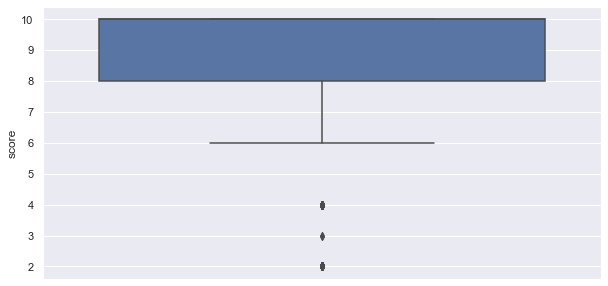

In [284]:
plt.figure(figsize= (10,5));

# plt.subplot(1,1,1);
sns.boxplot(df_fin['score'],orient='v');

From the above plot we can observe that there are outliers towards lower bound after value 6. Let us treat this outliers and check the results again.

Using IQR, we can follow the below approach to replace the outliers with a NULL value and later impute them:
- Calculate the first and third quartile (Q1 and Q3).
- Further, evaluate the interquartile range, IQR = Q3-Q1.
- Estimate the lower bound, the lower bound = Q1*1.5
- Estimate the upper bound, upper bound = Q3*1.5
- Replace the data points that lie outside of the lower and the upper bound with a NULL value.

In [285]:
for x in ['score']:
    q75,q25 = np.percentile(df_fin.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df_fin.loc[df_fin[x] < min,x] = np.nan
    df_fin.loc[df_fin[x] > max,x] = np.nan

After calculating Q1 and Q3, we have replaced the outliers with null values. Having replaced the outliers with null values, let us now check the sum of null values or missing values using the below code:

In [286]:
df_fin.isnull().sum()

date         0
lang         0
country      0
source       0
score      367
author       0
product      0
dtype: int64

We will impute null values using KNN imputer. KNN imputer can be more accurate than the mean, median or mode imputation methods. Since we are dealing with relatively small dataset computational speed is negligible.

In [287]:
null_col = ['score']

#Technique 2: Using median to impute the missing values
for i in null_col:
 df_fin.loc[df_fin.loc[:,i].isnull(),i]=df_fin.loc[:,i].median()

print("Count of NULL values after imputation\n")
df_fin.isnull().sum()

Count of NULL values after imputation



date       0
lang       0
country    0
source     0
score      0
author     0
product    0
dtype: int64

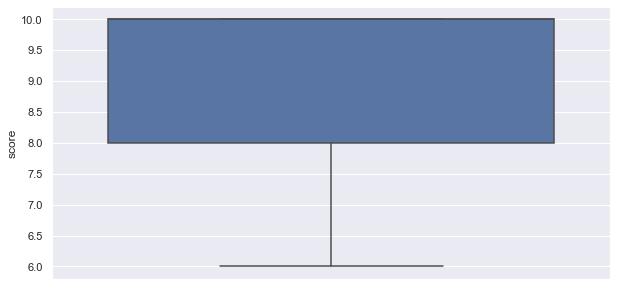

In [288]:
plt.figure(figsize= (10,5));

# plt.subplot(1,1,1);
sns.boxplot(df_fin['score'],orient='v');

Let us again apply SVD on our new dataset in which outliers are replaced with median.

In [289]:
# Let's keep only auhtor, product and score columns in our dataset.
df_3col = df_fin.filter(['author','product','score'])
df_3col.head()

,author,product,score
0,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",10.0
1,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1...",10.0
2,Cliente Amazon,Lenovo Motorola Moto G 4G 3 Generazione Smartp...,10.0
3,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",10.0
4,einem Kunden,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1...",10.0


In [290]:
surprise_data = Dataset.load_from_df(df_3col, reader)

# Split the data into train and test
trainset_or, testset_or = train_test_split(surprise_data, test_size=0.3, random_state=10)

In [291]:
# Giving parameters for search CV to find best model
params= {
    "n_epochs": [5, 10, 15, 20, 25],
    "lr_all": [0.002, 0.005, 0.01, 0.02],
    "reg_all": [0.2, 0.4, 0.6, 0.8, 1]
    }
clf_or = find_best_model(SVD, params, surprise_data)

{'rmse': 1.096768207730904}
{'rmse': {'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.2}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002228F1FBF40>}


In [292]:
# Giving inputs to recommender
svd_or = clf_or.best_estimator['rmse']
col_fil_svd_or = collab_filtering_based_recommender(svd_or, trainset_or, testset_or, surprise_data)

In [293]:
# Calculating RMSE
svd_rmse_or = col_fil_svd_or.fit_and_predict_product()

<span style='color:blue'>**Fitting the train data...**</span>

<span style='color:blue'>**Predicting the test data...**</span>

RMSE: 1.1199


<span style='color:blue'>**RMSE for the predicted result is 1.12**</span>

In [294]:
#cross validate
svd_cv_rmse_or = col_fil_svd_or.cross_validate()

<span style='color:blue'>**Cross Validating the data...**</span>

<span style='color:blue'>**Mean CV RMSE is 1.095**</span>

The mean RMSE has improved a lot after using dataset in which outliers are imputed using median and cross validated. 1.09 seems to be a good RMSE value for our dataset. Let us now recommend top 5 products for users.

In [295]:
# Recommend
result_svd_user1 = col_fil_svd_or.recommend_product(author_name='e-bit', n=5)
result_svd_user2 = col_fil_svd_or.recommend_product(author_name='einem Kunden', n=5)
result_svd_user3 = col_fil_svd_or.recommend_product(author_name='Cliente Amazon', n=5)

<span style='color:blue'>**Recommending top 5 products for user e-bit :**</span>

,author,product,score
0,e-bit,Smartphone LG G2 D805,9.598906
1,e-bit,Smartphone Asus ZenFone 3 ZE552KL,9.510458
2,e-bit,Smartphone Apple iPhone 6 16GB,9.491189
3,e-bit,Smartphone Samsung Galaxy S7 SM-G930 32GB,9.458195
4,e-bit,Smartphone Motorola Moto X 2Âª GeraÃ§Ã£o XT109...,9.457791


<span style='color:blue'>**Recommending top 5 products for user einem Kunden :**</span>

,author,product,score
0,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",9.803233
1,einem Kunden,"Apple iPhone 7 4,7"" 32 GB",9.771671
2,einem Kunden,"Samsung Galaxy S7 edge Smartphone, 13,9 cm (5,...",9.755700
3,einem Kunden,"Apple iPhone 6s Plus 5,5"" 128 GB",9.742773
4,einem Kunden,"Apple iPhone 7 Plus 5,5"" 128 GB",9.671321


<span style='color:blue'>**Recommending top 5 products for user Cliente Amazon :**</span>

,author,product,score
0,Cliente Amazon,Samsung G935 Galaxy S7 Edge Smartphone da 32GB...,9.493131
1,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",9.455965
2,Cliente Amazon,"Huawei P9 Lite Smartphone, LTE, Display 5.2'' ...",9.453551
3,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...,9.438117
4,Cliente Amazon,"Samsung J320 Galaxy J3 (2016) Dual SIM 5"", Qua...",9.282692


As we observed previously since the data set we used for collaborative recommender is having a combination of conditions where users who have given > 50 ratings __'AND'__ products having > 50 ratings, for item to item recommendation we have very less recommendations. Satisfying both conditions means though products have more than 50 reviews since many of the users who have rated those products have not rated more than 50 products, we are missing those data.

Item-Item based using KNNwithmeans on dataset in which outliers are removed. Since we observed that both SVD and KNNwithmeans collaborative methods are giving similar results we will use KNNwithmeans approach for item-item based recoommender.

In [296]:
sim_options1 = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [False],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options1}
clf1_or = find_best_model1(KNNWithMeans, params, surprise_data)

{'rmse': 1.1016423190487263}
{'rmse': {'k': 38, 'sim_options': {'name': 'pearson', 'min_support': 4, 'user_based': False}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000222BEEA4340>}


In [297]:
knnwithmeans1_or = clf1_or.best_estimator['rmse']
col_fil_knnwithmeans1_or = collab_filtering_based_recommender1(knnwithmeans1_or, trainset_or, testset_or, surprise_data)

In [298]:
knnwithmeans_rmse1_or = col_fil_knnwithmeans1_or.fit_and_predict_user()

<span style='color:blue'>**Fitting the train data...**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.


<span style='color:blue'>**Predicting the test data...**</span>

RMSE: 1.1287


<span style='color:blue'>**RMSE for the predicted result is 1.129**</span>

In [299]:
knnwithmeans_cv_rmse1_or = col_fil_knnwithmeans1_or.cross_validate1()

<span style='color:blue'>**Cross Validating the data...**</span>

<span style='color:blue'>**Mean CV RMSE is 1.1**</span>

Similar to user-user based collaborative recommender we can observe that RMSE has improved from 1.8 to 1.1 after removing outliers. RMSE close to 1 will comparitively give good predictions.

In [300]:
result_knn_user1 = col_fil_knnwithmeans1_or.recommend_user(prod_name='Apple iPhone 7 4,7" 32 GB', n=5)
result_knn_user2 = col_fil_knnwithmeans1_or.recommend_user(prod_name='Smartphone Samsung Galaxy Gran Prime TV SM-G530', n=5)
result_knn_user3 = col_fil_knnwithmeans1_or.recommend_user(prod_name='Apple iPhone 6s 4,7" 128 GB', n=5)

<span style='color:blue'>**Recommending top users for product Apple iPhone 7 4,7" 32 GB :**</span>

,author,product,score
0,einer Kundin,"Apple iPhone 7 4,7"" 32 GB",9.947368
1,einem Kunden,"Apple iPhone 7 4,7"" 32 GB",9.736842


<span style='color:blue'>**Recommending top users for product Smartphone Samsung Galaxy Gran Prime TV SM-G530 :**</span>

,author,product,score
0,e-bit,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.210526


<span style='color:blue'>**Recommending top users for product Apple iPhone 6s 4,7" 128 GB :**</span>

,author,product,score
0,einem Kunden,"Apple iPhone 6s 4,7"" 128 GB",9.947368
1,einer Kundin,"Apple iPhone 6s 4,7"" 128 GB",9.842105


Since we are not able to recommend more users for particular products, let's use a dataset in which products have > 50 reviews __'OR'__ users who have given > 50 reviews i.e., not all the users or products are having > 50 reviews.

In [301]:
df_tst1 = df_samp.groupby(["product"]).filter(lambda x:x['score'].count() >=50)
df_tst2 = df_samp.groupby(["author"]).filter(lambda x:x['score'].count() >=50)
df_tst = pd.concat([df_tst1,df_tst2], axis=0)
df_tst = df_tst.reset_index(drop=True)
df_tst.shape

(684946, 7)

In [302]:
df_tst = df_tst.drop_duplicates(subset=['author', 'product', 'score'], keep='first', inplace=False, ignore_index=False)
df_tst.shape

(584538, 7)

In [303]:
# Sampling data to keep only 25000 rows 
df_tst = df_tst.sample(n=25000, random_state=100)
print('Shape of data file after sampling is: {}'.format(df_tst.shape))

Shape of data file after sampling is: (25000, 7)


In [304]:
# Lets remove outliers for better results
for x in ['score']:
    q75,q25 = np.percentile(df_tst.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df_tst.loc[df_tst[x] < min,x] = np.nan
    df_tst.loc[df_tst[x] > max,x] = np.nan

In [305]:
null_col1 = ['score']

#Technique 2: Using median to impute the missing values
for i in null_col1:
 df_tst.loc[df_tst.loc[:,i].isnull(),i]=df_tst.loc[:,i].median()

# print("Count of NULL values after imputation\n")
# df_tst.isnull().sum()

In [306]:
# plt.figure(figsize= (10,5));

# # plt.subplot(1,1,1);
# sns.boxplot(df_tst['score'],orient='v');

In [307]:
# Let's keep only auhtor, product and score columns in our dataset.
df_tst_3col = df_tst.filter(['author','product','score'])
# df_tst_3col.head()

In [308]:
surprise_tst = Dataset.load_from_df(df_tst_3col, reader)

# Split the data into train and test
trainset_tst, testset_tst = train_test_split(surprise_tst, test_size=0.3, random_state=10)

In [311]:
sim_options_tst = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [False],
}
params = { 'k': range(30,50,1), 'sim_options': sim_options_tst}
clf1_tst = find_best_model1(KNNWithMeans, params, surprise_tst)

{'rmse': 1.319062183235066}
{'rmse': {'k': 48, 'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000222EA0FEA60>}


In [312]:
knnwithmeans1_tst = clf1_tst.best_estimator['rmse']
col_fil_knnwithmeans1_tst = collab_filtering_based_recommender1(knnwithmeans1_tst, trainset_tst, testset_tst, surprise_tst)

In [313]:
knnwithmeans_rmse1_tst = col_fil_knnwithmeans1_tst.fit_and_predict_user()

<span style='color:blue'>**Fitting the train data...**</span>

Computing the cosine similarity matrix...
Done computing similarity matrix.


<span style='color:blue'>**Predicting the test data...**</span>

RMSE: 1.3306


<span style='color:blue'>**RMSE for the predicted result is 1.331**</span>

In [314]:
knnwithmeans_cv_rmse1_tst = col_fil_knnwithmeans1_tst.cross_validate1()

<span style='color:blue'>**Cross Validating the data...**</span>

<span style='color:blue'>**Mean CV RMSE is 1.321**</span>

In [315]:
result_knn_user1 = col_fil_knnwithmeans1_tst.recommend_user(prod_name='OnePlus 3 (Graphite, 64 GB)', n=5)
result_knn_user2 = col_fil_knnwithmeans1_tst.recommend_user(prod_name='Smartphone Samsung Galaxy Gran Prime TV SM-G530', n=5)
result_knn_user3 = col_fil_knnwithmeans1_tst.recommend_user(prod_name='Motorola Moto G, 4th Gen (Black, 2 GB, 16 GB)', n=5)

<span style='color:blue'>**Recommending top users for product OnePlus 3 (Graphite, 64 GB) :**</span>

,author,product,score
0,Karthikeyan,"OnePlus 3 (Graphite, 64 GB)",9.551020
1,Vishal Mhatre,"OnePlus 3 (Graphite, 64 GB)",9.116057
2,Sumit Sharma,"OnePlus 3 (Graphite, 64 GB)",9.116057
3,Amsarajan N,"OnePlus 3 (Graphite, 64 GB)",9.116057
4,siva,"OnePlus 3 (Graphite, 64 GB)",9.116057


<span style='color:blue'>**Recommending top users for product Smartphone Samsung Galaxy Gran Prime TV SM-G530 :**</span>

,author,product,score
0,juliano amigo cor...,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.116057
1,giz??lia,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.116057
2,bruno moura,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.116057
3,carol madeiro,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.116057
4,rayan,Smartphone Samsung Galaxy Gran Prime TV SM-G530,9.116057


<span style='color:blue'>**Recommending top users for product Motorola Moto G, 4th Gen (Black, 2 GB, 16 GB) :**</span>

,author,product,score
0,Anant,"Motorola Moto G, 4th Gen (Black, 2 GB, 16 GB)",9.116057
1,prem,"Motorola Moto G, 4th Gen (Black, 2 GB, 16 GB)",9.116057
2,Shailendra Kumar Yadav,"Motorola Moto G, 4th Gen (Black, 2 GB, 16 GB)",9.116057
3,pratibha t.,"Motorola Moto G, 4th Gen (Black, 2 GB, 16 GB)",9.116057
4,Koustove,"Motorola Moto G, 4th Gen (Black, 2 GB, 16 GB)",9.116057


We can observe that mean RMSE has slightly increased for the new dataset used but we are able to give more recommendations for products. The users in the new dataset may or may not have given more than 50 reviews. We have already discussed why we have used this dataset above. Since the combination of conditions where users who have given > 50 ratings __'AND'__ products having > 50 ratings are giving very less recommendations of users for particular items.

Thus we have tried multiple approaches on datasets as well as models and acheived good recommendations and predictions with RMSE values being close to 1.

__Popularity-Based Recommendation System:__ It is a type of recommendation system which works on the principle of popularity and or anything which is in trend. These systems check about the product or movie which are in trend or are most popular among the users and directly recommend those.

We use this type of recommendation engines in:
- Google News: News filtered by trending and most popular news.
- YouTube: Trending videos.

Limitations:
- Not personalized.
- The system would recommend the same sort of products/movies which are solely based upon popularity to every other user.

__Collaborative Filtering based Recommendation Systems:__ It is considered to be one of the very smart recommender systems that work on the similarity between different users and also items that are widely used as an e-commerce website and also online movie websites. It checks about the taste of similar users and does recommendations. 

We use this type of recommendation engines in:
- Amazon: To recommend products which are brought together.
- Social Networks: To recommend new friends/connections.

Limitations:
- Cold start problem: Enough users required to find a match __*(Similar to the issue we faced in the above dataset for item-item recommendation)*__. To overcome such cold start problems, often hybrid approaches are made use of between CF and Content-based matching. 
- Scalability: Even if there are many users and many items that are to be recommended often, problems can arise of user and rating matrix to be sparse and will become challenging to find out about the users who have rated the same item.
- Sparsity: The problem in recommending items to the user due to sparsity problems.

__Hybrid Recommendation systems:__ Most recommender systems now use a hybrid approach, combining collaborative filtering, content-based filtering, and other approaches . Hybrid approaches can be implemented in several ways: by making content-based and collaborative-based predictions separately and then combining them; by adding content-based capabilities to a collaborative-based approach (and vice versa); or by unifying the approaches into one model. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem, as well as the knowledge engineering bottleneck in knowledge-based approaches.

Netflix is a good example of the use of hybrid recommender systems. The website makes recommendations by comparing the watching and searching habits of similar users (i.e., collaborative filtering) as well as by offering movies that share characteristics with films that a user has rated highly (content-based filtering).

Some hybridization techniques include:

Weighted: Combining the score of different recommendation components numerically.
Switching: Choosing among recommendation components and applying the selected one.
Mixed: Recommendations from different recommenders are presented together to give the recommendation.
Feature Combination: Features derived from different knowledge sources are combined together and given to a single recommendation algorithm.
Feature Augmentation: Computing a feature or set of features, which is then part of the input to the next technique.
Cascade: Recommenders are given strict priority, with the lower priority ones breaking ties in the scoring of the higher ones.
Meta-level: One recommendation technique is applied and produces some sort of model, which is then the input used by the next technique.